# DISPLAY MAPS

## Display sea ice statistics maps in the Weddell Sea using .nc files
- Read netCDF files for the sea ice statistics
- Draw sea ice statistics maps in the Weddell Sea

Credited by Younghyun Koo (kooala317@gmail.com)

## (1) Import necessary libraries

In [99]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import h5py
import matplotlib.pylab as plt
from matplotlib import gridspec
from math import *
import netCDF4
import xarray as xr
from netCDF4 import date2num,num2date
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from pyproj import Proj, transform
import geopandas as gpd


%reload_ext autoreload
%autoreload 2

from functions_floes import *

## (2) Read .nc file

### Old version (directly read nc file)

In [4]:
# Enter name of the .nc file
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_w_ibfiltering.nc'

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    print(keys)
    
    # X/Y coordinates and lat/lon on the NSIDC sea ice stereogeographic south
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    
    # Times in seconds from 1800/01/01
    times = np.array(nc.variables['time'])
    t = num2date(nc.variables['time'], nc.variables['time'].units)
    
    # Freeboard statistics
    fmode = np.array(nc.variables['fb_mode'])
    # fmean = np.array(nc.variables['fb_mean'])
    # fmed = np.array(nc.variables['fb_med'])
    fstd = np.array(nc.variables['fb_std'])
    fridge = np.array(nc.variables['fr_ridge'])
    hridge = np.array(nc.variables['h_ridge'])
    # flead = np.array(nc.variables['fr_lead'])
    
    # # Floe statistics
    # # flen = np.array(nc.variables['floe_len'])
    # # fcnt = np.array(nc.variables['floe_cnt'])
    # ibcnt = np.array(nc.variables['ib_cnt'])

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead', 'floe_len', 'floe_cnt', 'ib_cnt'])


In [3]:
# Enter name of the .nc file without iceberg filtering
ncname = f'D:\\Floes\\array\\Grid_fb_v6_entire_S_wo_ibfiltering.nc'

with netCDF4.Dataset(ncname, 'r') as nc:
    keys = nc.variables.keys()
    print(keys)
    
#     # X/Y coordinates and lat/lon on the NSIDC sea ice stereogeographic south
#     x = np.array(nc.variables['x'])
#     y = np.array(nc.variables['y'])
#     xx, yy = np.meshgrid(x, y)
#     lat = np.array(nc.variables['lat'])
#     lon = np.array(nc.variables['lon'])
    
#     # Times in seconds from 1800/01/01
#     times = np.array(nc.variables['time'])
#     t = num2date(nc.variables['time'], nc.variables['time'].units)
    
    # Freeboard statistics
    fmode0 = np.array(nc.variables['fb_mode'])
    # fmean = np.array(nc.variables['fb_mean'])
    # fmed = np.array(nc.variables['fb_med'])
    fstd0 = np.array(nc.variables['fb_std'])
    fridge0 = np.array(nc.variables['fr_ridge'])
    hridge0 = np.array(nc.variables['h_ridge'])
    # flead = np.array(nc.variables['fr_lead'])
    
    # Floe statistics
    # flen = np.array(nc.variables['floe_len'])
    # fcnt = np.array(nc.variables['floe_cnt'])
    # ibcnt = np.array(nc.variables['ib_cnt'])

dict_keys(['x', 'y', 'time', 'lat', 'lon', 'fb_mode', 'fb_mean', 'fb_med', 'fb_std', 'fr_ridge', 'h_ridge', 'fr_lead', 'floe_len', 'floe_cnt', 'ib_cnt'])


### New version (read through xarray)

In [19]:
# Enter name of the .nc file
year = 2022
ncname = f'D:\\Floes\\array\\Grid_fb_v6_Ross{year}_w_ibfiltering_fb0.8.nc'
ds = xr.open_dataset(ncname)

ncname0 = f'D:\\Floes\\array\\Grid_fb_v6_Ross{year}_wo_ibfiltering.nc'
ds0 = xr.open_dataset(ncname0)

with netCDF4.Dataset(ncname, 'r') as nc:
    x = np.array(nc.variables['x'])
    y = np.array(nc.variables['y'])
    xx, yy = np.meshgrid(x, y)
    lat = np.array(nc.variables['lat'])
    lon = np.array(nc.variables['lon'])
    
    times = np.array(nc.variables['time'])
    t = num2date(nc.variables['time'], nc.variables['time'].units)

In [15]:
ds.close()
ds0.close()

## (3) Draw maps in the Weddell Sea

### Number of landfast ice

In [3]:
projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

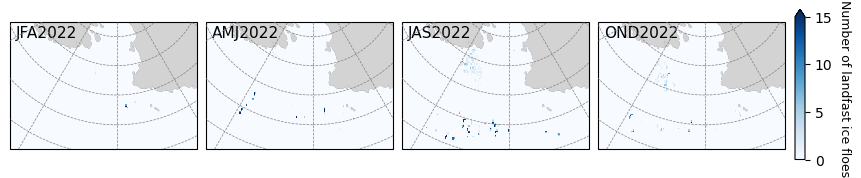

In [20]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0, 'ib_cnt': 0, 'ib_len': 0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5, 'ib_cnt': 15, 'ib_len': 1000}
labels = {'ib_cnt': 'Number of landfast ice floes', 'ib_len': 'Total along-track length of landfast ice'}


for field in ['ib_cnt']:

    value = np.transpose(np.array(ds[field]), axes = (0, 2, 1))
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 100, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:

        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--', zorder = 10)
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        # ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        # ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 2, color = "gray")
        ax[i].add_feature(cfeature.LAND, color = "lightgray", zorder = 2)
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nansum(value[idx], axis=0), shading = 'nearest',
                              vmin = vmin[field], vmax=vmax[field], cmap = "Blues")
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
        
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field], rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\Ross_{year}_{field}.png", bbox_inches = "tight")

### Dynamic sea ice features

In [4]:
projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)

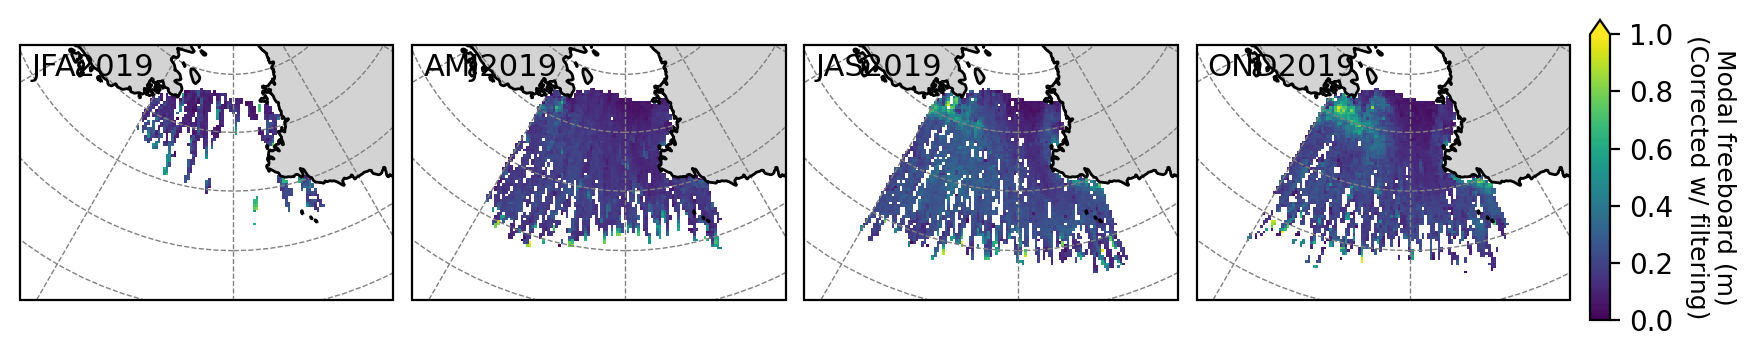

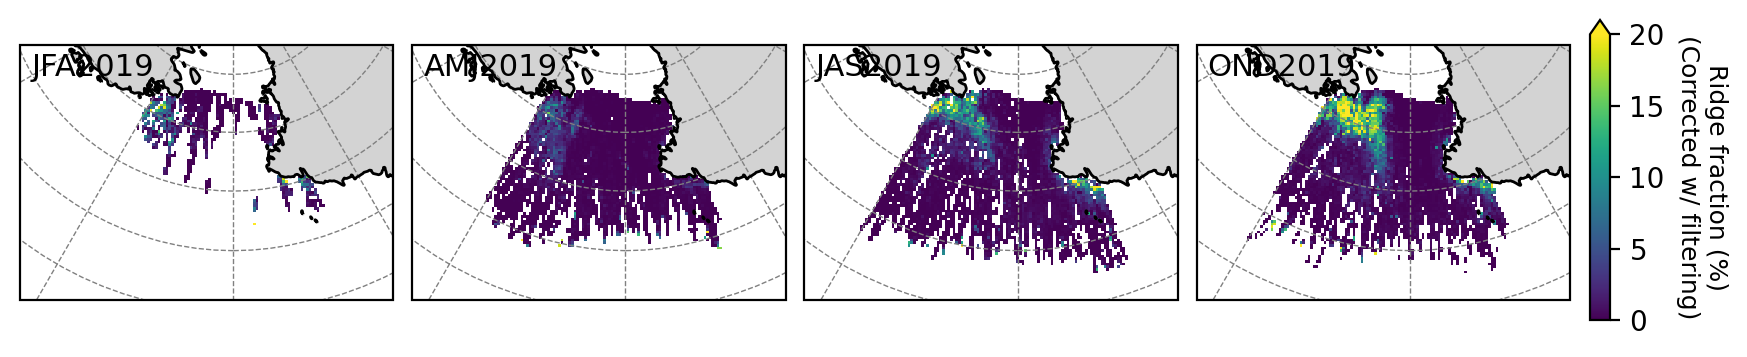

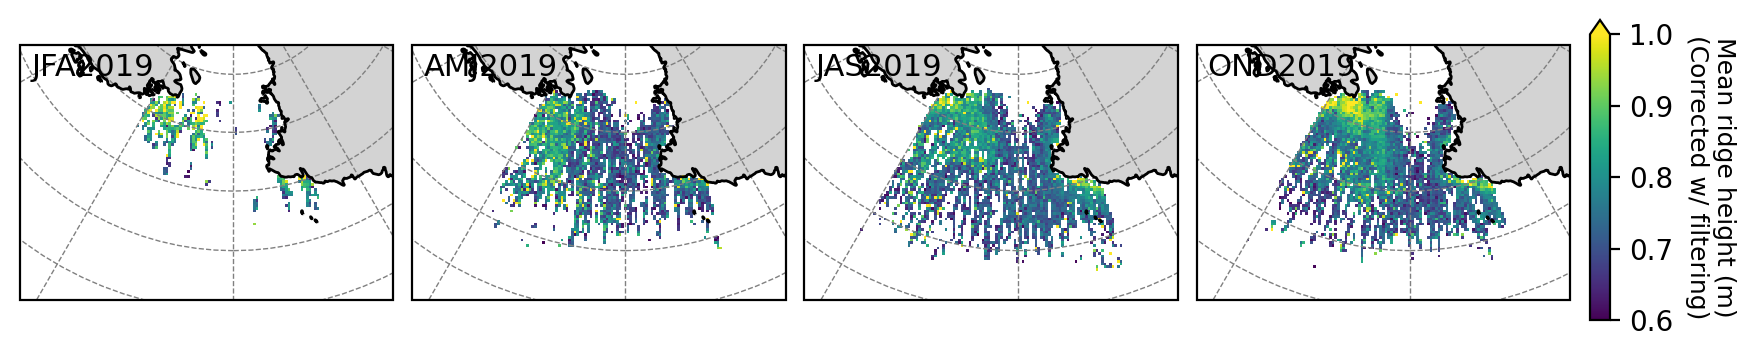

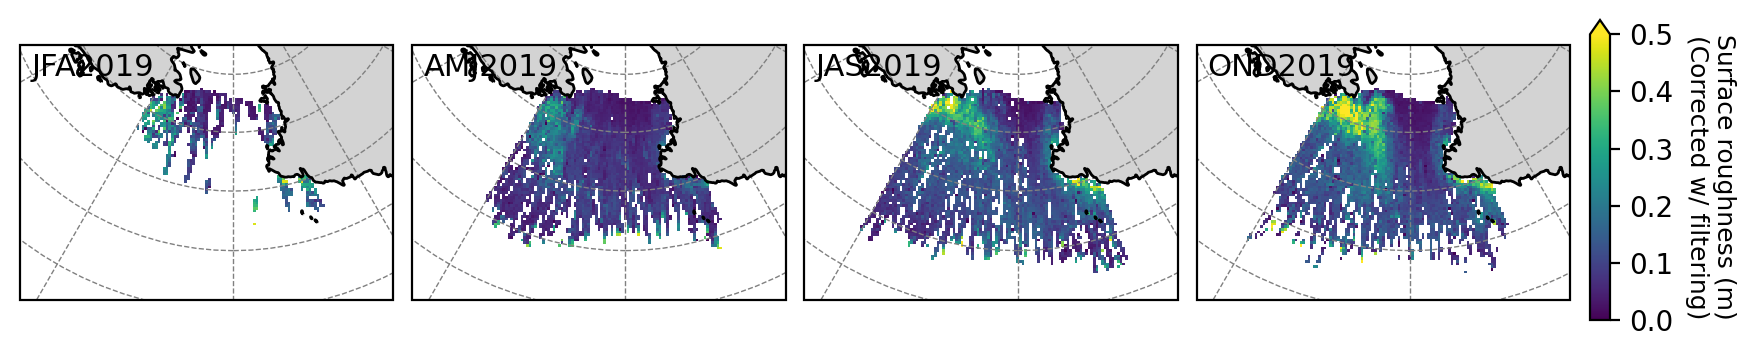

In [5]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:

    value = np.transpose(np.array(ds[field]), axes = (0, 2, 1))

    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 200, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        # ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        # ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field])
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field] + "\n(Corrected w/ filtering)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\Ross_{year}_Correct_{field}.png", bbox_inches = "tight")

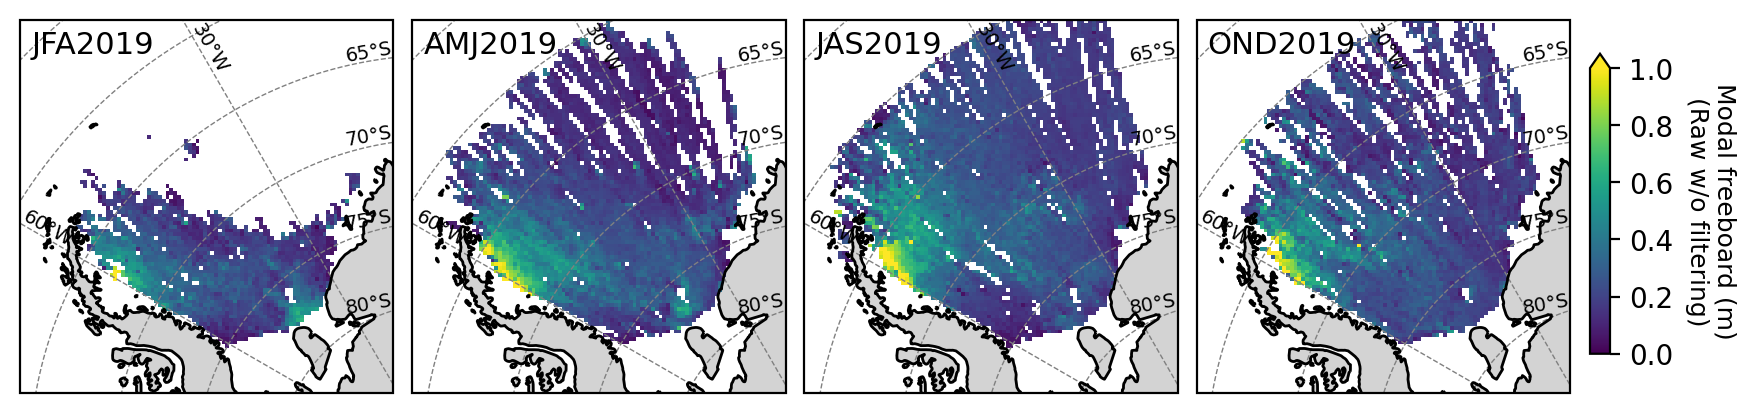

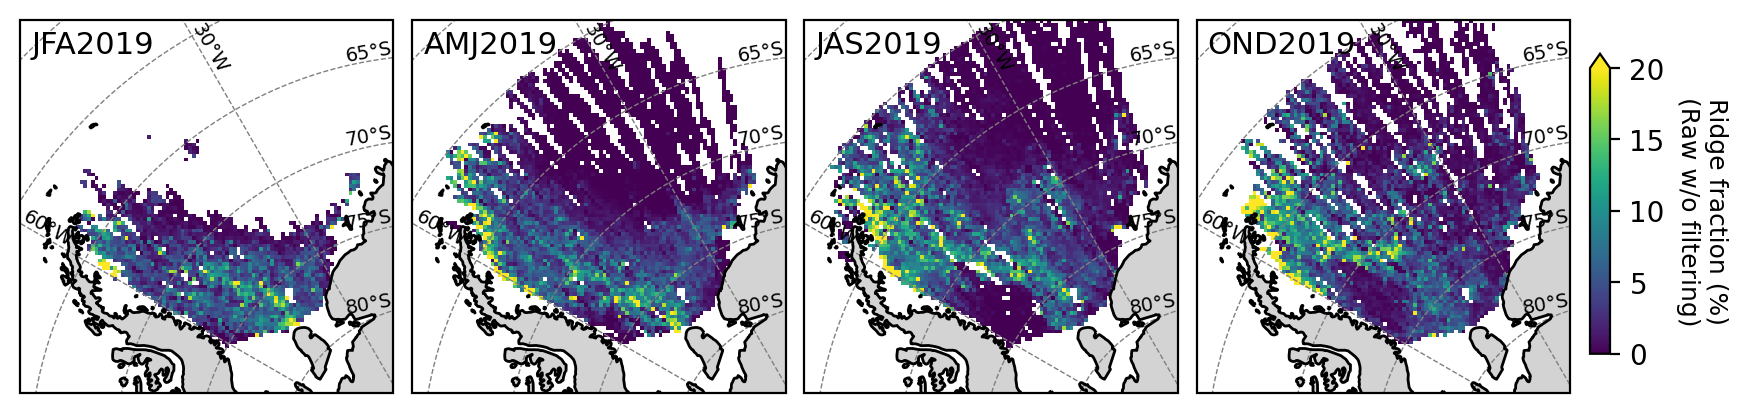

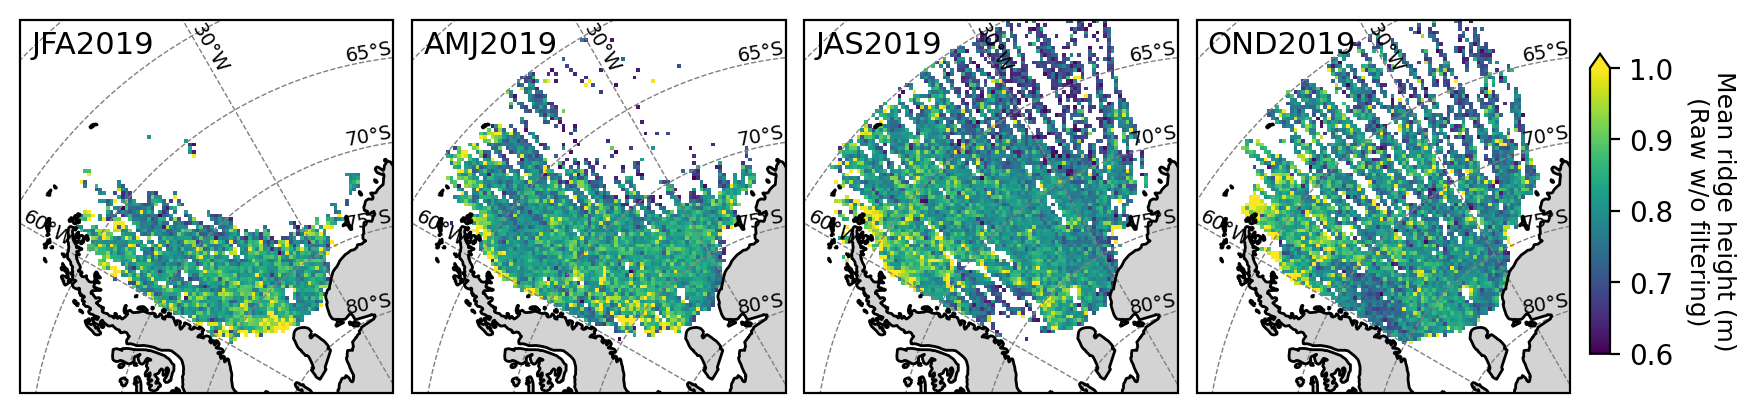

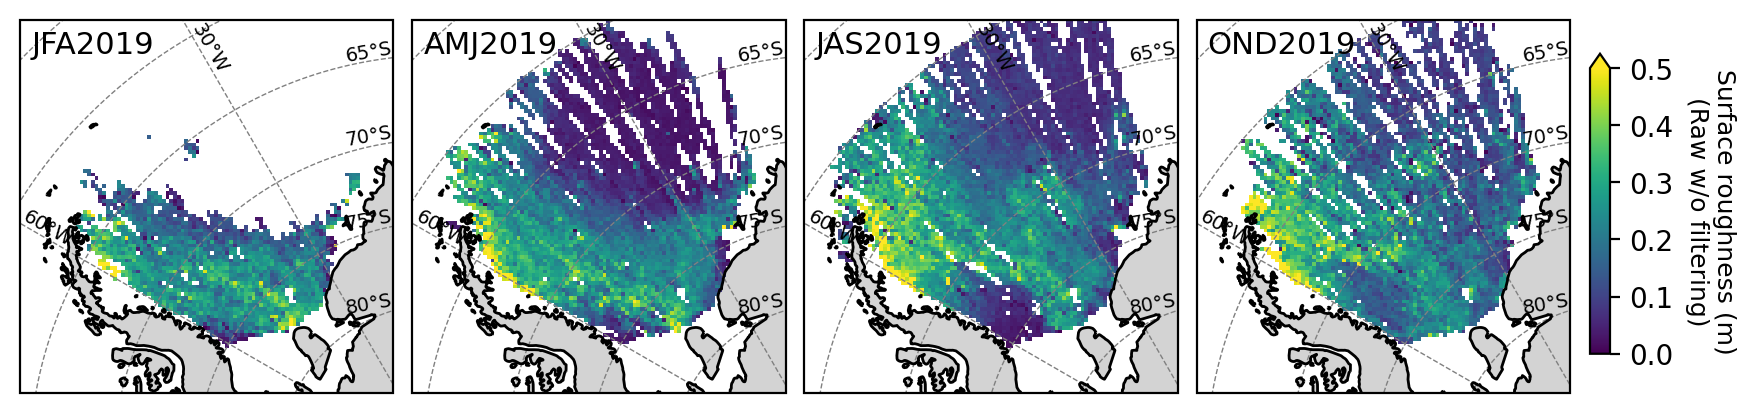

In [5]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0}
vmax = {'fb_mode':1.0, 'fr_ridge':20, 'h_ridge':1.0, 'fb_std':0.5}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.transpose(np.array(ds[field]), axes = (0, 2, 1))
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 200, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6]) #[left, bottom, width, height] of the new axes.

    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(value[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field])
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "max")
    cb.set_label(labels[field] + "\n(Raw w/o filtering)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\Ross_{year}_Raw_{field}.png", bbox_inches = "tight")

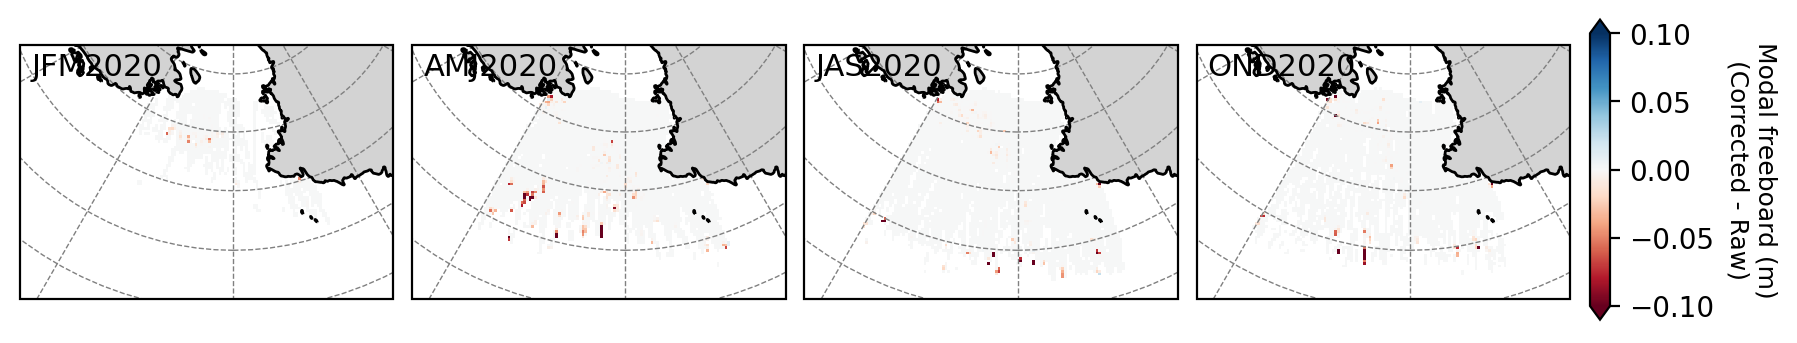

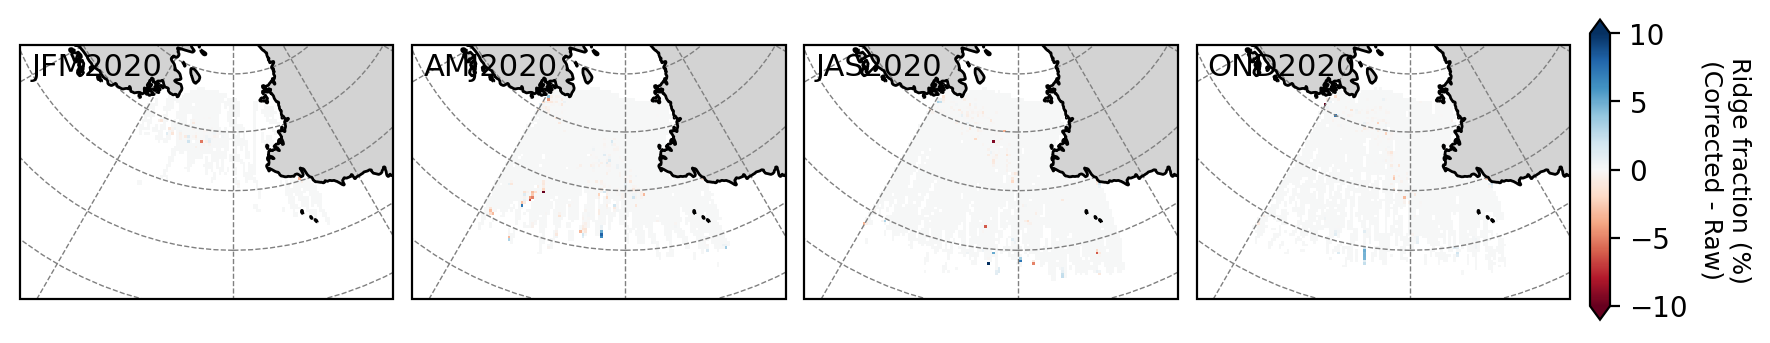

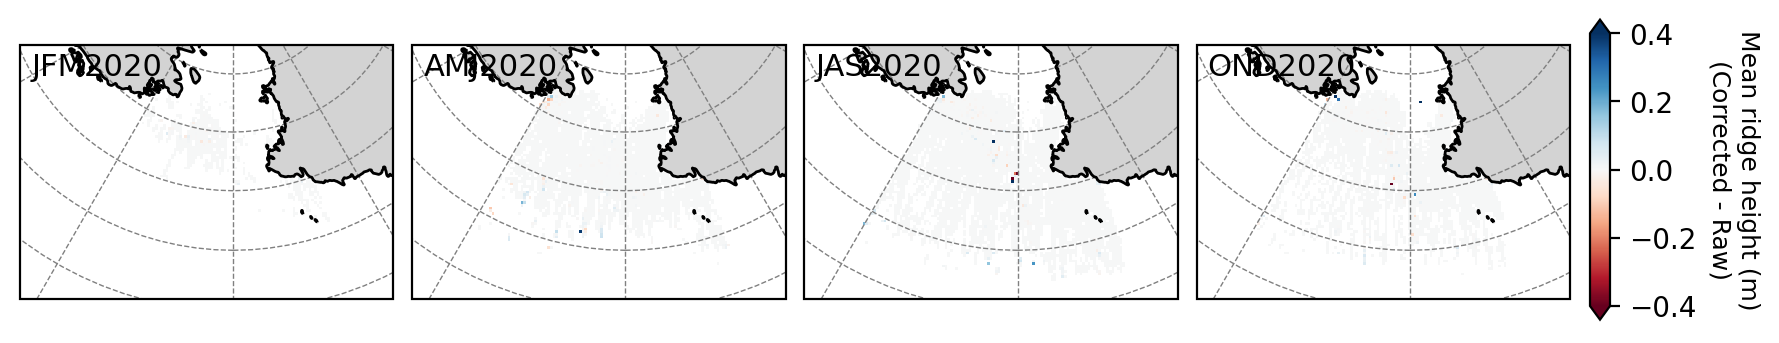

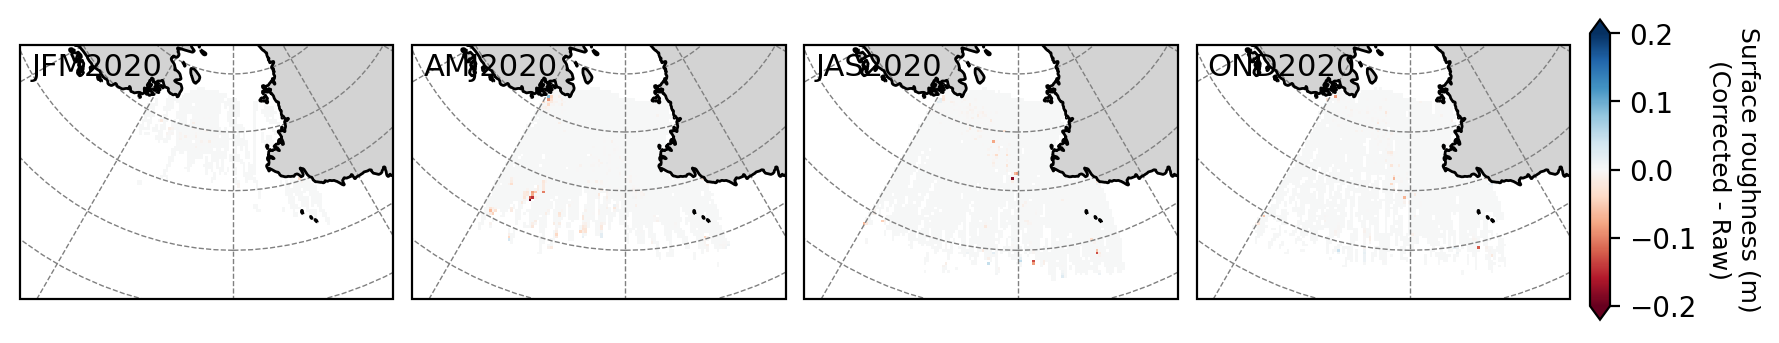

In [8]:
vmin = {'fb_mode':-0.1, 'fr_ridge':-10, 'h_ridge':-0.4, 'fb_std':-0.2}
vmax = {'fb_mode':0.1, 'fr_ridge':10, 'h_ridge':0.4, 'fb_std':0.2}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

cnt = np.array(ds['ib_len'])

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.transpose(np.array(ds[field]), axes = (0, 2, 1))
    value0 = np.transpose(np.array(ds0[field]), axes = (0, 2, 1))
    val_diff = value - value0
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 2.5), dpi= 200, subplot_kw={'projection': projection})
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    cb_ax = fig.add_axes([.91,.2,.01,.6])
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, xlocs = np.arange(-180, 180, 30),
                              linewidth=0.5, color='grey', linestyle='--')
    
        gl.ylabel_style = {'size': 7, 'color': 'k', 'ha': 'left', 'rotation': 0}
        gl.xlabel_style = {'size': 7, 'color': 'k', 'ha': 'center', 'rotation': 0}
        gl.top_labels = False #False #False #False
        gl.bottom_labels = False #False #False
        gl.left_labels = False
        gl.right_labels = False
    
        # ax[i].annotate('30°W', xy=(0.45, 1.0), xycoords='axes fraction', rotation = -60, size = 7, va = 'top', ha ='left')
        # ax[i].annotate('60°W',xy=(0.0, 0.5), xycoords='axes fraction', rotation = -30, size = 7, va = 'top', ha ='left')
        
        # ax[i].annotate('65°S', xy=(1.0, 0.95), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('70°S',xy=(1.0, 0.725), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('75°S', xy=(1.0, 0.5), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        # ax[i].annotate('80°S', xy=(1.0, 0.275), xycoords='axes fraction', rotation = 10, size = 7, va = 'top', ha ='right')
        
        ax[i].coastlines(zorder = 10)
        ax[i].add_feature(cfeature.LAND, color = "lightgray")
        
        idx = (t >= date1) & (t < date3)
        # m = ax.pcolormesh(xx, yy, np.nanmean(ibcnt[idx], axis=0)-np.nanmean(ibcnt[idx], axis=0))
        cnt_sum = np.nansum(cnt[idx], axis = 0)
        maxi, maxj = np.where(cnt_sum == np.nanmax(cnt_sum))
        maxi = maxi[0]
        maxj = maxj[0]
        
        pm = ax[i].pcolormesh(xx, yy, np.nanmean(val_diff[idx], axis=0),
                          vmin = vmin[field], vmax=vmax[field], cmap = "RdBu")

        w = 10
        # ax[i].plot([xx[maxi-w, maxj-w], xx[maxi+w+1, maxj-w], xx[maxi+w+1, maxj+w+1], xx[maxi-w, maxj+w+1], xx[maxi-w, maxj-w]],
        #          [yy[maxi-w, maxj-w], yy[maxi+w+1, maxj-w], yy[maxi+w+1, maxj+w+1], yy[maxi-w, maxj+w+1], yy[maxi-w, maxj-w]],
        #          color = "green", ls = "--", lw = 1)
        # m = ax.pcolormesh(xx, yy, np.nanmean(fmode0[idx], axis=0), vmin = 0, vmax = 1.0)
        # fig.colorbar(m, ax=ax[i], shrink = 0.7, label = "Modal freeboard (m)", extend = "both")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
    
    cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "both")
    cb.set_label(labels[field] + "\n(Corrected - Raw)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\Ross_{year}_Diff_{field}.png", bbox_inches = "tight")

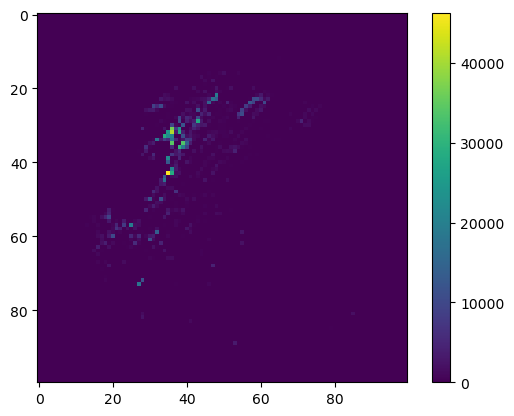

In [9]:
plt.imshow(cnt_sum)
plt.colorbar()

#### Draw histograms

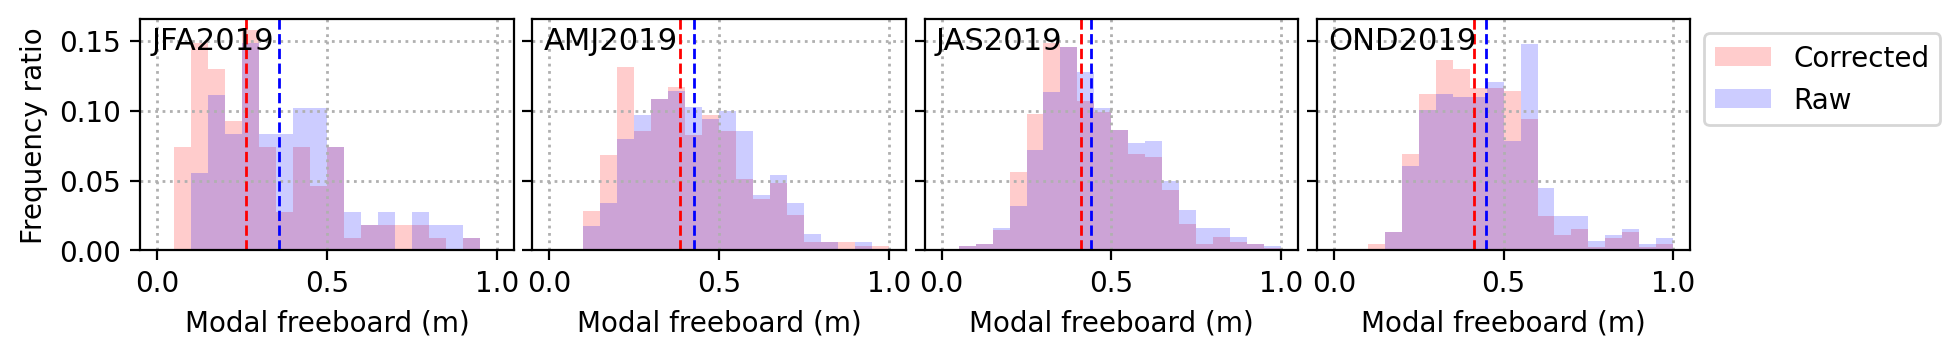

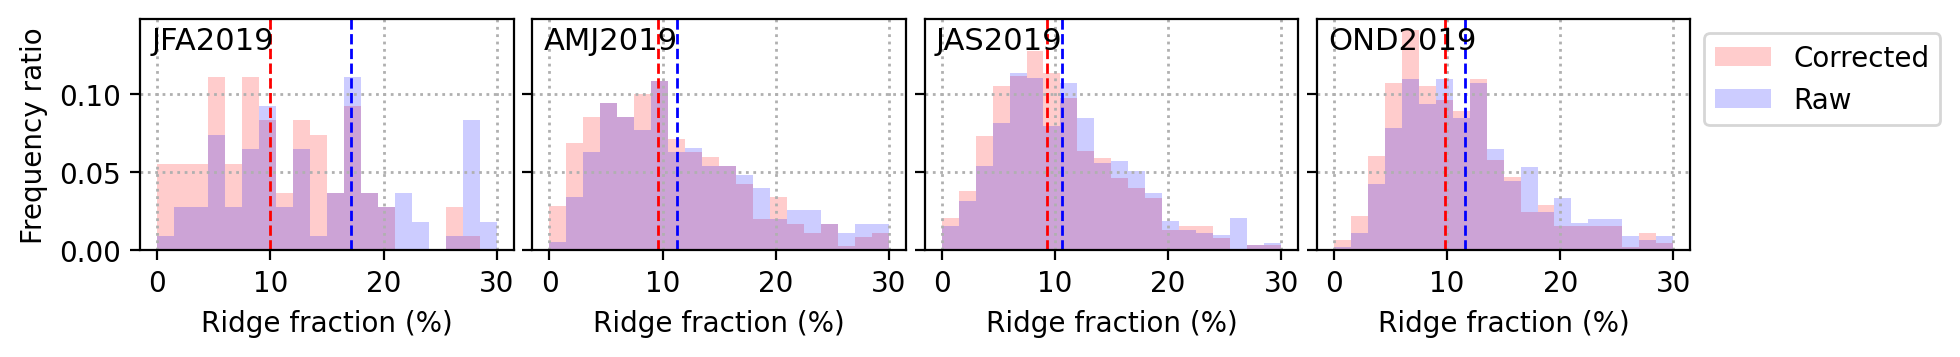

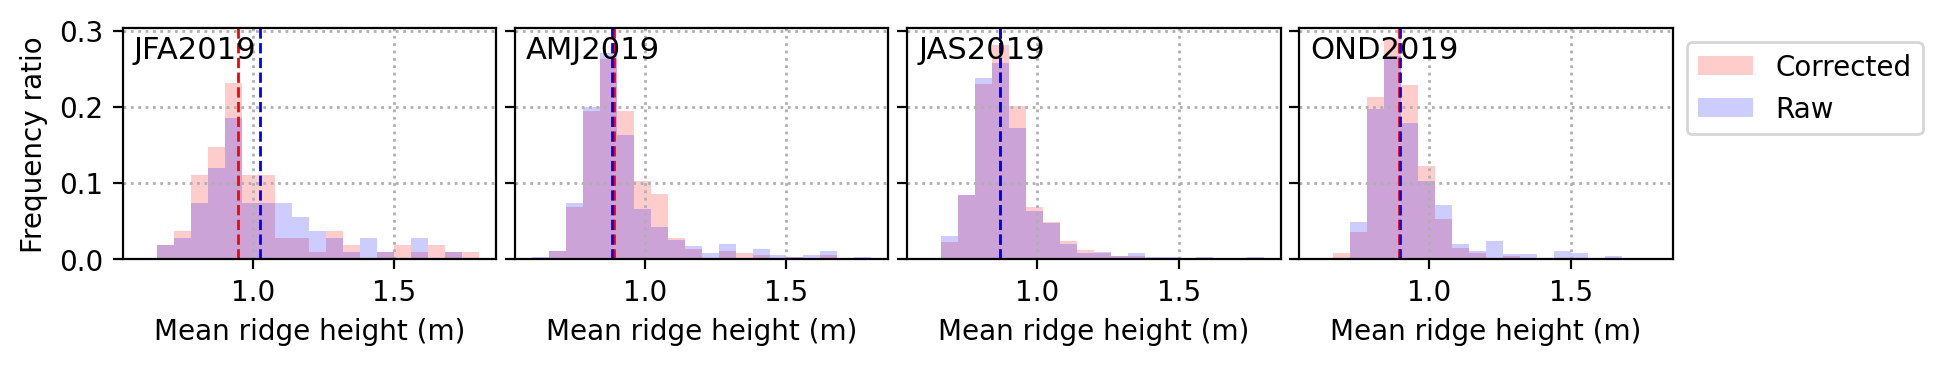

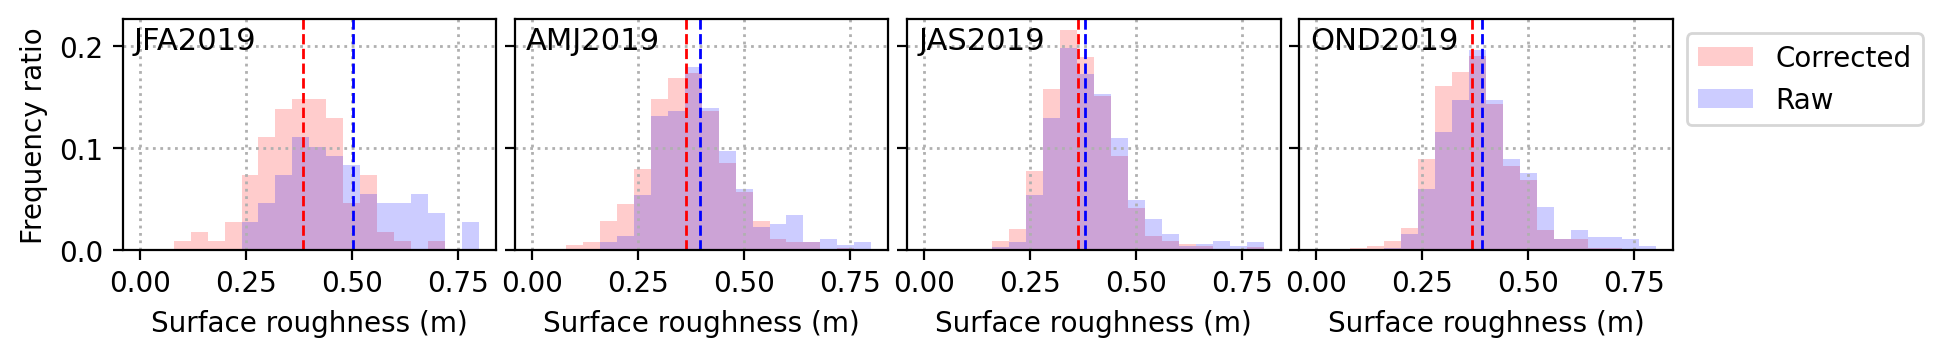

In [19]:
vmin = {'fb_mode':0, 'fr_ridge':0, 'h_ridge':0.6, 'fb_std':0}
vmax = {'fb_mode':1.0, 'fr_ridge':30, 'h_ridge':1.8, 'fb_std':0.8}
labels = {'fb_mode':'Modal freeboard (m)', 'fr_ridge': 'Ridge fraction (%)',
          'h_ridge':'Mean ridge height (m)', 'fb_std': 'Surface roughness (m)'}

cnt = np.transpose(np.array(ds['ib_len']), axes = (0, 2, 1))

for field in ['fb_mode', 'fr_ridge', 'h_ridge', 'fb_std']:
    value = np.transpose(np.array(ds[field]), axes = (0, 2, 1))
    value0 = np.transpose(np.array(ds0[field]), axes = (0, 2, 1))
    val_diff = value - value0
    
    fig, ax = fig, ax = plt.subplots(1, 4, figsize=(10, 1.5), dpi= 200, sharey = True)
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    # cb_ax = fig.add_axes([.91,.2,.01,.6])
    
    for i, month in enumerate([1, 4, 7, 10]):# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    
        date1 = dt.datetime(year, month, 1)
        date2 = date1 + dt.timedelta(days = 45) #dt.datetime(2019, 9, 1)
        date3 = date1 + dt.timedelta(days = 90) #dt.datetime(2019, 9, 1)
    
        m1 = date1.strftime("%b")[0]
        m2 = date2.strftime("%b")[0]
        m3 = date3.strftime("%b")[0]
        
        idx = (t >= date1) & (t < date3)
        cnt_sum = np.nansum(cnt[idx], axis = 0)
        maxi, maxj = np.where(cnt_sum == np.nanmax(cnt_sum))
        maxi = maxi[0]
        maxj = maxj[0]
        w = 10
        idx2 = np.where(cnt[idx] > 500)
        ax[i].hist(value[idx][idx2].flatten(), range = (vmin[field], vmax[field]), bins = 20, label = "Corrected",
                   color = "red", histtype = 'bar', alpha = 0.2, lw=1, weights=np.ones(len(idx2[0])) / len(idx2[0]))
        ax[i].axvline(np.nanmedian(value[idx][idx2]), ls = "--", lw = 1, color = "red")
        ax[i].hist(value0[idx][idx2].flatten(), range = (vmin[field], vmax[field]), bins = 20, label = "Raw",
                   color = "blue", histtype = 'bar', alpha = 0.2, lw = 1, weights=np.ones(len(idx2[0])) / len(idx2[0]))
        ax[i].axvline(np.nanmedian(value0[idx][idx2]), ls = "--", lw = 1, color = "blue")
        ax[i].annotate(f"{m1}{m2}{m3}{year}", xy=(0.03, 0.97), xycoords='axes fraction', va = "top", fontsize=11)
        ax[i].set_xlabel(labels[field])
        ax[i].grid(ls = ":", lw = 1)
        if i == 0:
            ax[i].set_ylabel("Frequency ratio")
        if i == 3:
            ax[i].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        # ax[i].set_ylim(0, 0.35)
    
    # cb = fig.colorbar(pm, orientation='vertical', cax=cb_ax, ax = ax, pad = 0.01, extend = "both")
    # cb.set_label(labels[field] + "\n(Corrected - Raw)", rotation = 270, va = "bottom", fontsize = 9)
    plt.savefig(f"D:\\Floes\\figures\\IB_histogram_{field}.png", bbox_inches = "tight")

In [135]:
idx2[0]

array([  3,   9,  11,  11,  13,  13,  18,  18,  18,  18,  18,  18,  18,
        18,  18,  18,  18,  18,  18,  18,  22,  22,  22,  22,  22,  22,
        22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  24,
        24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,  24,
        24,  24,  26,  26,  26,  26,  26,  26,  26,  26,  26,  28,  28,
        28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
        28,  28,  28,  33,  33,  33,  34,  36,  36,  36,  36,  36,  36,
        38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,  38,
        38,  38,  38,  38,  38,  38,  38,  38,  38,  40,  40,  45,  45,
        47,  47,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
        54,  54,  55,  55,  55,  55,  55,  55,  55,  55,  55,  55,  55,
        55,  55,  55,  55,  55,  55,  57,  57,  62,  62,  62,  63,  63,
        63,  63,  63,  63,  63,  63,  65,  65,  65,  65,  65,  65,  65,
        65,  65,  67,  67,  67,  67,  67,  67,  70,  70,  72,  7

In [102]:
value.shape

(1005, 100, 100)

In [87]:
## Must close the file!!
ds.close()
ds0.close()

## Track landfast ice

In [297]:
year = 2020

th_fb = 0.8
th_sigma = 0.02
th_std = 0.1
df_all = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_Ross_{year}_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)
df_all = df_all[df_all['lat'] < -70].reset_index(drop=True)

bbox = [160, -80, -150, -60]

In [298]:
for i in range(0, len(df_all)):
    df_all.loc[i, "jday"] = int(dt.datetime(df_all.loc[i, "year"], df_all.loc[i, "month"], df_all.loc[i, "day"]).strftime("%j"))

In [299]:
df_count = df_all.groupby(["filename", "beam"]).sum()
files = df_count.sort_values(by = "width", ascending = False).loc[:, ['lat']].head(30).index.unique() #.sort_values()

In [300]:
for i, _ in enumerate(files):
    print(i, files[i])

0 ('ATL10-02_20200524075640_08980701_006_01.h5', 'gt2l')
1 ('ATL10-02_20200524075640_08980701_006_01.h5', 'gt3l')
2 ('ATL10-02_20201121231616_08980901_006_01.h5', 'gt2l')
3 ('ATL10-02_20200524075640_08980701_006_01.h5', 'gt1l')
4 ('ATL10-02_20200920164644_13340801_006_02.h5', 'gt3l')
5 ('ATL10-02_20201121231616_08980901_006_01.h5', 'gt3l')
6 ('ATL10-02_20200925033827_00150901_006_02.h5', 'gt2l')
7 ('ATL10-02_20200622063240_13400701_006_01.h5', 'gt2l')
8 ('ATL10-02_20200421092857_03950701_006_02.h5', 'gt1r')
9 ('ATL10-02_20200328022725_00240701_006_01.h5', 'gt1r')
10 ('ATL10-02_20200622063240_13400701_006_01.h5', 'gt3l')
11 ('ATL10-02_20201121231616_08980901_006_01.h5', 'gt1l')
12 ('ATL10-02_20200605073139_10810701_006_01.h5', 'gt3l')
13 ('ATL10-02_20200921021228_13400801_006_02.h5', 'gt1l')
14 ('ATL10-02_20200425092038_04560701_006_02.h5', 'gt1r')
15 ('ATL10-02_20201021015708_04110901_006_01.h5', 'gt3l')
16 ('ATL10-02_20200818164444_08300801_006_01.h5', 'gt1l')
17 ('ATL10-02_2020092102

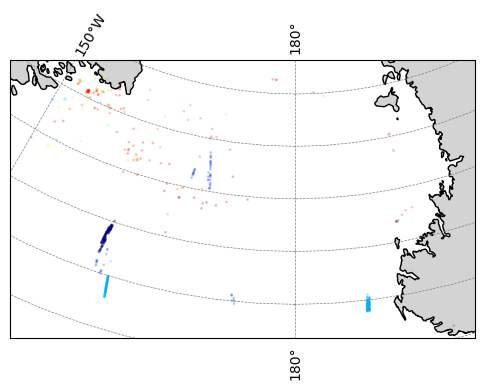

In [225]:
x, y = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), df_all['lat'], df_all['lon'])

fig, ax = fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                      linewidth=0.5, color='grey', linestyle='--')
    
gl.xlabels_top = True
gl.xlabels_bottom = True
# gl.xlabels_left = True
# gl.xlabels_right = True
gl.ylabels_left = True
gl.ylabels_right = True

ax.coastlines()
# ax.stock_img()
ax.add_feature(cfeature.LAND, color = "lightgray")
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.OCEAN)

# width = 2500000
# ax.set_xlim(-2800000, -3000000 + width)
# ax.set_ylim(300000, 100000 + width)

ax.scatter(x, y, c = df_all['jday'], s = df_all['fb_mean'], alpha = 0.2, cmap = "jet")

In [301]:
n = 1 # 12 (2022)
filename = "D:\\Ross\\ATL10_h5\\" + files[n][0]
beam = files[n][1]

# beam_nums = df_all.loc[df_all['filename'] == files[n], "beam_num"].unique()
print(filename, beam)

D:\Ross\ATL10_h5\ATL10-02_20200524075640_08980701_006_01.h5 gt3l


In [302]:
ib_filtering = False

with h5py.File(filename,'r') as f:
    # print(filename)
    # Check the orbit orientation

    df_raw = read_ATL10(filename, bbox)
    df = df_raw.loc[df_raw['beam']==beam, :].reset_index(drop = True)

    # th_fb2 = np.where(df['fb_mode']+0.6 > th_fb, df['fb_mode']+0.6, th_fb)
    ib_mask2, df_ib = determine_iceberg(df, th_fb, th_sigma, th_std)
    df_ib2, ib_mask3 = combine_icebergs(df, df_ib, ib_mask2, th_fb = 0.8)
    df['ib_mask'] = ib_mask3.astype(int)

    if ib_filtering:
        df = df[ib_mask3 == 0].reset_index(drop = True)
    ######################################################
    lat = df['lat'].values
    lon = df['lon'].values
    seg_x = df['seg_x'].values
    seg_len = df['seg_len'].values
    fb = df['fb'].values
    stype = df['stype'].values
    refsur_ndx = df['refsur_ndx'].values

    freeboard_mode, sample_ndx = modal_profile(fb, seg_x, refsur_ndx)

    ridge = np.zeros(np.shape(fb))
    # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
    ridge[fb > freeboard_mode + 0.6] = 1

    df['fb_mode'] = freeboard_mode
    df['ridge'] = ridge

gdf_ib = gpd.GeoDataFrame(df_ib2)

print(filename)

D:\Ross\ATL10_h5\ATL10-02_20200524075640_08980701_006_01.h5


(-3000000.0, -500000.0)

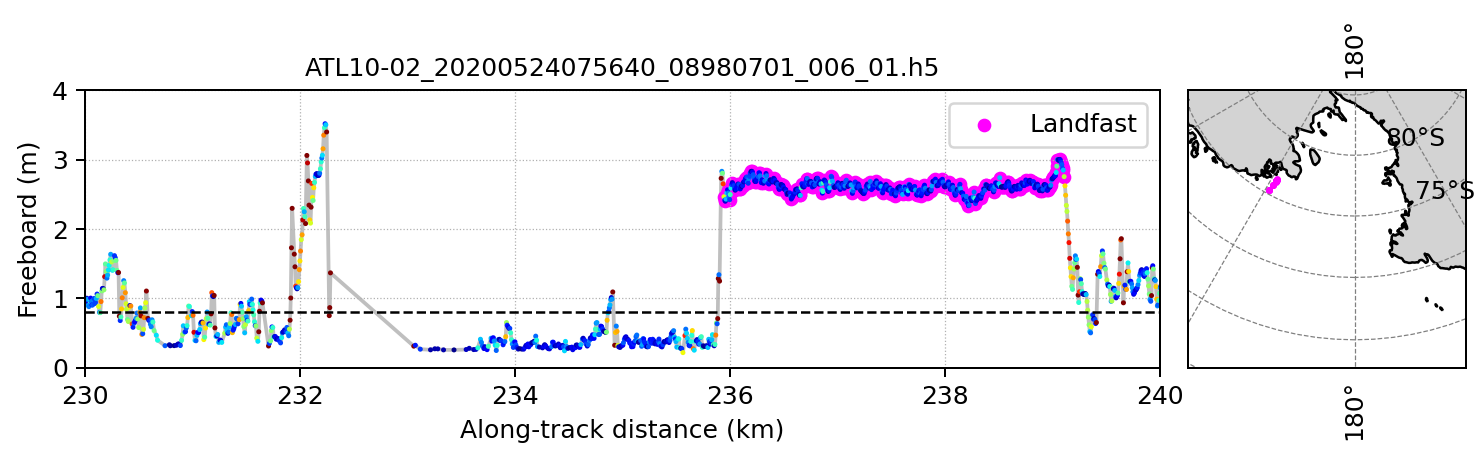

In [306]:
%matplotlib inline

fig = plt.figure(figsize=(10,2), dpi = 180)
 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[3.5, 1], wspace=0.02)

ax1 = fig.add_subplot(spec[0])

projection = ccrs.SouthPolarStereo(central_longitude=0, true_scale_latitude = -70)
ax2 = fig.add_subplot(spec[1],projection=projection)

# pm = ax.pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax1.plot(df['seg_x']/1000, df['fb'], c="gray", zorder=1, alpha = 0.5)
# ax1.plot(df['seg_x']/1000, df['fb_mode'], c="k", zorder=10)
sc = ax1.scatter(df['seg_x']/1000, df['fb'], c=df['fb_std'], s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby

# sc = ax.scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax1.scatter(df['seg_x'][ib_mask3]/1000, df['fb'][ib_mask3], s= 20, c = "magenta", zorder = 1, marker = "o", label="Landfast")
# std. freeboard nearby
# sc = ax.scatter(seg_x[ib_mask3]/1000 - seg_min, fb[ib_mask3]*0 + 4.2, s= 20, c = "magenta", zorder = 1, marker = "o")
# std. freeboard nearby
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma
ax1.legend()

# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax1.axhline(th_fb, ls = "--", lw = 1, c="k", zorder=2)
# ax.plot(df['seg_x']/1000, th_fb, c="k")
# ax1.vlines(df['seg_x'][ib_mask3]/1000, 0, 5, color="lightpink", zorder = 0, alpha = 0.5, lw = 1)

ax1.set_title(os.path.basename(filename), fontsize = 10)
ax1.grid(ls = ":", lw = 0.5)

ax1.set_ylabel("Freeboard (m)");

ax1.set_ylim(0, 4);
ax1.set_xlim(230, 240);
ax1.set_xlabel("Along-track distance (km)")

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                   linewidth=0.5, color='grey', linestyle='--')

x, y = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), gdf_ib['lat'], gdf_ib['lon'])
ax2.scatter(x, y, s = 3, c = "magenta")

ax2.coastlines()
ax2.add_feature(cfeature.LAND, color = "lightgray")

width = 2500000
ax2.set_xlim(-1500000, 1000000)
ax2.set_ylim(-3000000, -500000)

In [237]:
ib_mask3

array([False, False, False, ..., False, False, False])

D:\Ross\ATL10_h5\ATL10-02_20220921042314_00071701_006_01.h5 9 473


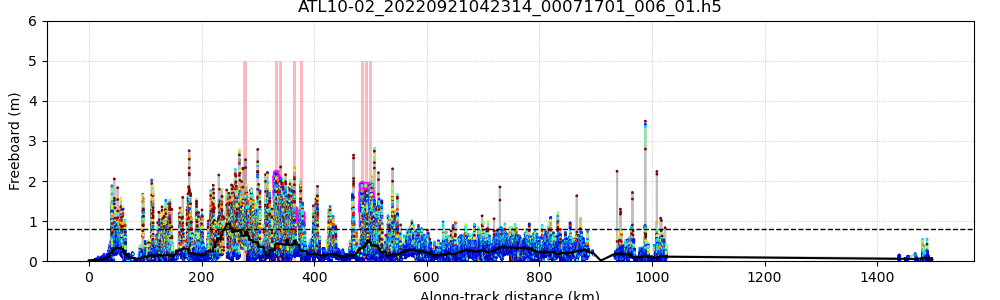

In [98]:
%matplotlib widget
print(filename, len(df_ib2), sum(ib_mask3))
fig, ax = plt.subplots(1,1, figsize = (10, 3))
fig.tight_layout()

# pm = ax.pcolormesh(xx, yy, ratio, zorder = 0, cmap = "Blues")
ax.plot(df['seg_x']/1000, df['fb'], c="gray", zorder=1, alpha = 0.5)
ax.plot(df['seg_x']/1000, df['fb_mode'], c="k", zorder=10)
sc = ax.scatter(df['seg_x']/1000, df['fb'], c=df['fb_std'], s= 1, cmap = "jet", vmax = 0.2, zorder = 2) # std. freeboard nearby

# sc = ax.scatter(seg_x[ib_mask], fb[ib_mask], s= 2, c = "yellow", zorder = 6) # std. freeboard nearby
sc = ax.scatter(df['seg_x'][ib_mask3]/1000, df['fb'][ib_mask3], s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x[ib_mask3]/1000 - seg_min, fb[ib_mask3]*0 + 4.2, s= 20, c = "magenta", zorder = 1, marker = "o") # std. freeboard nearby
# sc = ax.scatter(seg_x, fb, c=sigma, s= 1, cmap = "jet", vmax = 0.02) # sigma

# ax.axhline(1, ls = "--", lw = 1, c="w", zorder=2)
ax.axhline(th_fb, ls = "--", lw = 1, c="k", zorder=2)
# ax.plot(df['seg_x']/1000, th_fb, c="k")
ax.vlines(df['seg_x'][ib_mask3]/1000, 0, 5, color="lightpink", zorder = 0, alpha = 0.5, lw = 1)

ax.set_title(os.path.basename(filename))
ax.grid(ls = ":", lw = 0.5)

ax.set_ylabel("Freeboard (m)");

ax.set_ylim(0, 6);

ax.set_xlabel("Along-track distance (km)")

plt.show()
# plt.close()

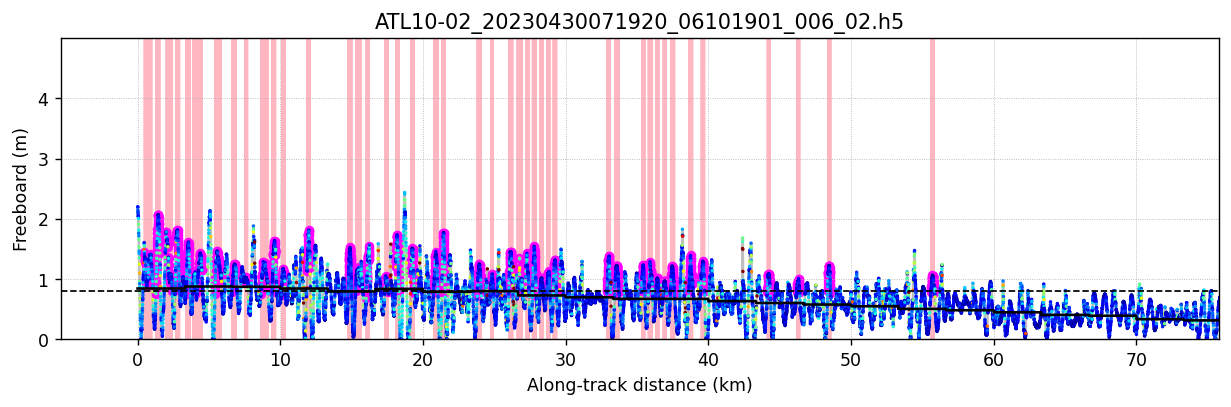

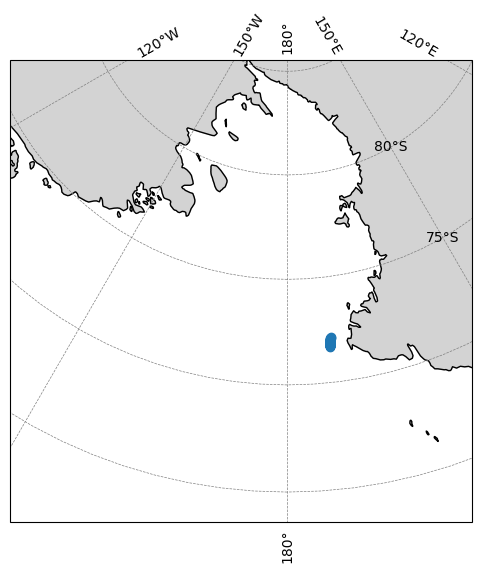

In [124]:
# plt.close()
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, xlocs = np.arange(-180, 180, 30),
                      linewidth=0.5, color='grey', linestyle='--')

x, y = transform(Proj("EPSG:4326"), Proj("EPSG:3412"), gdf_ib['lat'], gdf_ib['lon'])
ax.scatter(x, y)

ax.coastlines()
# ax.stock_img()
ax.add_feature(cfeature.LAND, color = "lightgray")

width = 2500000
ax.set_xlim(-1500000, 1000000)
ax.set_ylim(-3000000, -500000)
plt.show()

## Sensitivity analysis

In [29]:
k

493

0.8
0.9
1.0


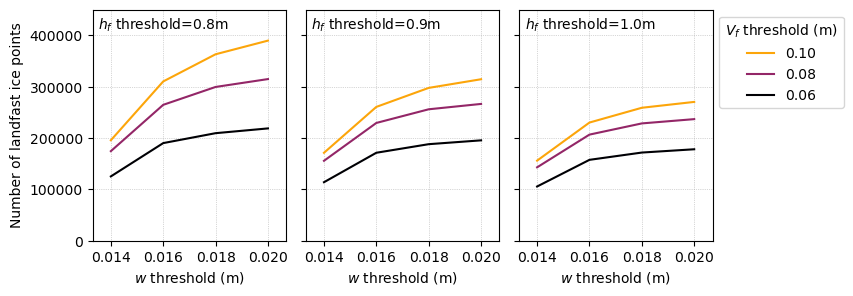

In [55]:
region = "Weddell"

th_fbs = [0.8, 0.9, 1.0]
sigmas = [0.02, 0.018, 0.016, 0.014]
stds = [0.1, 0.08, 0.06]

plg, ax = plt.subplots(1,3,figsize = (8,3), dpi = 100, sharey = True)
plt.subplots_adjust(hspace=0.1, wspace=0.1)

for year in [2019]:
    for n, th_fb in enumerate(th_fbs):

        count_points = np.zeros((len(sigmas), len(stds)))
    
        for i, th_sigma in enumerate(sigmas):
            for j, th_std in enumerate(stds):
    
                df = pd.read_csv(f"D:\\Floes\\icebergs\\Icebergs_{region}_{year}_fb{th_fb}_sigma{th_sigma}_std{th_std}.csv", index_col = 0)
                
                for k in range(0, len(df)):
                    count_points[i,j] += df.loc[k, 'id_en'] - df.loc[k, 'id_st'] + 1
                    
        cmap = matplotlib.cm.get_cmap('inferno')


        for j, th_std in enumerate(stds):
            color = cmap((th_std - min(stds))/(max(stds) - min(stds)+0.01))
            ax[n].plot(sigmas, count_points[:, j], label = f"{th_std:.2f}", color = color)
        
        # ax[n].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        
        ax[n].set_xlabel('$w$ threshold (m)')
        ax[n].grid(ls = ":", lw = 0.5)
        ax[n].set_ylim(0, 450000)
        ax[n].set_xlim(0.0133, 0.0207)
        # plt.savefig(f"D:\\Documents\\Submit_paper\\Landfast_Weddell\\Number_of_ib_fb{th_fb}.png", bbox_inches = "tight")
        print(th_fb)

        ax[n].annotate(f"$h_f$ threshold={th_fb}m", xy=(0.03, 0.97), xycoords='axes fraction', va = 'top', ha ='left')

ax[0].set_ylabel('Number of landfast ice points')
ax[n].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
ax[n].get_legend().set_title("$V_f$ threshold (m)")
plt.savefig("D:\Documents\Submit_paper\Landfast_Weddell\Fig11.png", bbox_inches = "tight")

Text(0.5, 0, 'Std. of Freeboard')

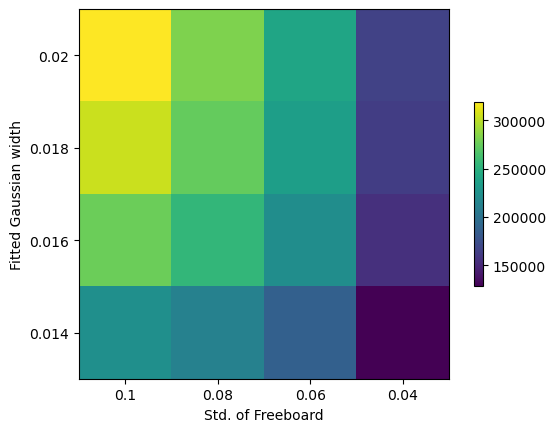

In [85]:
plt.imshow(count_points)
plt.xticks(range(0, len(stds)), stds)
plt.yticks(range(0, len(sigmas)), sigmas)
plt.colorbar(shrink = 0.5)
plt.ylabel('Fitted Gaussian width')
plt.xlabel('Std. of Freeboard')

In [6]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

rgba = cmap(0.5)
print(rgba) 

(0.998077662437524, 0.9992310649750096, 0.7460207612456747, 1.0)


0.8


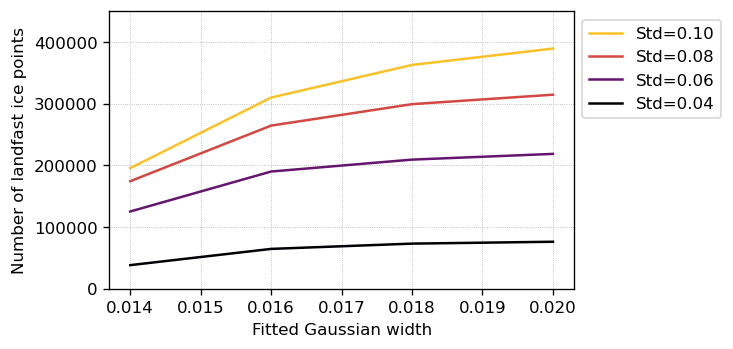

In [22]:
cmap = matplotlib.cm.get_cmap('inferno')

plt.figure(figsize = (5,3), dpi = 120)
for j, th_std in enumerate(stds):
    color = cmap((th_std - min(stds))/(max(stds) - min(stds)+0.01))
    plt.plot(sigmas, count_points[:, j], label = f"Std={th_std:.2f}", color = color)

plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.ylabel('Number of landfast ice points')
plt.xlabel('Fitted Gaussian width')
plt.grid(ls = ":", lw = 0.5)
plt.ylim(0, 450000)
plt.savefig(f"D:\\Documents\\Submit_paper\\Landfast_Weddell\\Number_of_ib_fb{th_fb}.png", bbox_inches = "tight")
print(th_fb)

In [ ]:
count_points = 0

for i in range(0, len(df_ib2)):
    count_points += df_ib2.loc[i, 'id_en'] - df_ib2.loc[i, 'id_st'] + 1

## Compare Iceberg and Sea ice features

In [2]:
import glob
from functions_floes import *

In [3]:
bbox = [-65, -77.6, -15, -62]

In [8]:
ib_files = glob.glob("D:\\Floes\\icebergs\\csvfiles\\*ib.csv")
ib_files

first = True

for f in ib_files:
    df_ib0 = pd.read_csv(f)

    df_ib0['fb_std'] = pd.Series(df_ib0['fb']).rolling(3, center = True).std().values
    beam = f[-11:-7]
    filename = "D:\\Floes\\ATL10\\{0}".format(os.path.basename(f)[:-12] + ".h5")
    df_raw = read_ATL10(filename, bbox)

    # for i in range(len(df_ib0)):
    #     try:
    #         df_ib0.loc[i, "fb_std"] = df_raw[df_raw['lon'] == df_ib0.loc[i, "lon"]]["fb_std"].values[0]
    #     except:
    #         df_ib0.loc[i, "fb_std"] = np.nan
    # df_raw = df_raw[(df_raw['beam'] == beam)]
    
    if first:
        df_ib = df_ib0
        first = False
    else:
        df_ib = pd.concat([df_ib, df_ib0], ignore_index = True)

In [9]:
si_files = glob.glob("D:\\Floes\\icebergs\\csvfiles\\*si.csv")
si_files

first = True

for f in si_files:
    df_si0 = pd.read_csv(f)
    df_si0['fb_std'] = pd.Series(df_si0['fb']).rolling(3, center = True).std().values

    # for i in range(len(df_si0)):
    #     try:
    #         df_si0.loc[i, "fb_std"] = df_raw[df_raw['lon'] == df_si0.loc[i, "lon"]]["fb_std"].values[0]
    #     except:
    #         df_si0.loc[i, "fb_std"] = np.nan
    
    if first:
        df_si = df_si0
        first = False
    else:
        df_si = pd.concat([df_si, df_si0], ignore_index = True)

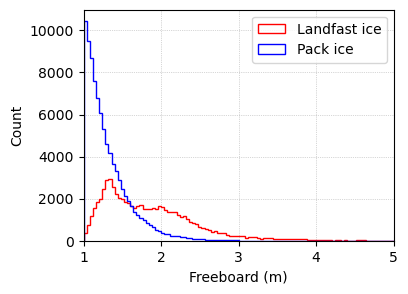

In [10]:
field = 'fb'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (1, 5), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (1, 5), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.015, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Freeboard (m)")
plt.legend()
plt.xlim(1,5)
plt.grid(ls = ":", lw = 0.5)

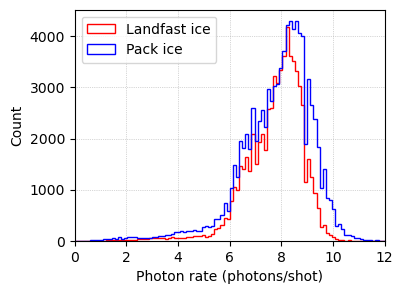

In [11]:
field = 'ph_rate'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 12), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 12), histtype="step", density = False, label = "Pack ice");
# plt.axvline(0.015, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Photon rate (photons/shot)")
plt.legend()
plt.xlim(0,12)
plt.grid(ls = ":", lw = 0.5)

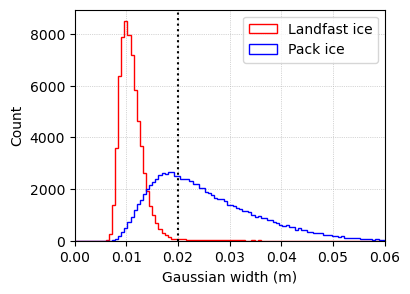

In [12]:
field = 'sigma'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 0.06), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 0.06), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.02, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Gaussian width (m)")
plt.legend()
plt.xlim(0,0.06)
plt.grid(ls = ":", lw = 0.5)

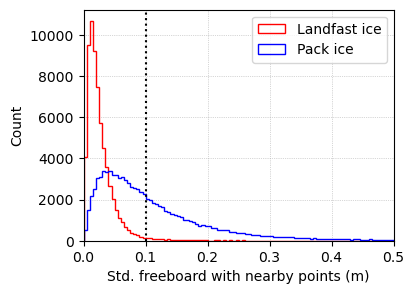

In [13]:
field = 'fb_std'
plt.subplots(1,1,figsize = (4,3))
plt.hist(df_ib[field], bins=100, color='red', range = (0, 0.5), histtype="step", density = False, label = "Landfast ice");
plt.hist(df_si[field], bins=100, color='blue', range = (0, 0.5), histtype="step", density = False, label = "Pack ice");
plt.axvline(0.1, c= "k", ls = ":")
plt.ylabel("Count")
plt.xlabel("Std. freeboard with nearby points (m)")
plt.legend()
plt.xlim(0,0.5)
plt.grid(ls = ":", lw = 0.5)